# 13. 심층 Q-러닝 (Deep Q-Learning)

**DQN(Deep Q-Network)**은 Q-Learning에 딥러닝(함수 근사)을 결합한 알고리즘이다. 아타리(Atari) 게임을 사람보다 잘하는 인공지능으로 유명해졌다.

DQN이 기존의 불안정한 딥러닝 기반 강화학습 문제를 해결하기 위해 도입한 핵심 기술은 두 가지다.

1. **경험 리플레이 (Experience Replay):** 에이전트가 겪은 데이터를 버퍼에 저장하고 무작위로 꺼내서 학습한다. 이는 데이터 간의 상관관계(Correlation)를 끊어 학습을 안정화시킨다.
2. **타겟 네트워크 (Target Network):** 정답지 역할을 하는 네트워크(Target)를 고정시켜 두고, 일정 주기마다 혹은 서서히 업데이트한다. 이는 학습 목표가 계속 흔들리는 문제를 방지한다.

### 0. 라이브러리 설정

최신 버전인 `gymnasium`과 `torch`를 불러온다.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from collections import deque
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

# GPU 사용 가능 여부 확인 및 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## 1. 환경 설정 및 전처리

이번 실습에서는 **CartPole-v1** 환경을 사용한다. 막대가 쓰러지지 않도록 카트를 좌우로 움직이는 문제다.
Gymnasium 환경의 데이터를 PyTorch 텐서로 변환해주는 래퍼(Wrapper)를 정의한다.

In [2]:
class PreprocessEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        # 관측값(numpy array)을 텐서로 변환하고 배치 차원(unsqueeze) 추가
        return torch.from_numpy(obs).float().unsqueeze(0).to(device), info

    def step(self, action):
        # 텐서 행동을 정수값으로 변환하여 환경에 전달
        action_item = action.item()
        next_obs, reward, terminated, truncated, info = self.env.step(action_item)

        # 다음 관측값도 텐서로 변환
        next_obs = torch.from_numpy(next_obs).float().unsqueeze(0).to(device)
        done = terminated or truncated
        return next_obs, reward, done, truncated, info

# 환경 생성 및 래퍼 적용
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = PreprocessEnv(env)

state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n

print(f"상태 차원: {state_dims}, 행동 개수: {num_actions}")

상태 차원: 4, 행동 개수: 2


---

## 2. Q-네트워크 (Q-Network) 정의

상태 를 입력받아 모든 행동에 대한 Q값 $Q(s, a)$를 출력하는 신경망을 정의한다.

In [3]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        # 은닉층 2개 사용 (128, 64 유닛)
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# 정책 네트워크(학습 대상)와 타겟 네트워크(정답지) 생성
q_network = QNetwork(state_dims, num_actions).to(device)
target_q_network = copy.deepcopy(q_network).to(device)
target_q_network.eval() # 타겟 네트워크는 학습 모드 아님 (평가 모드)

print(q_network)

QNetwork(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


---

## 3. 경험 리플레이 (Experience Replay)

데이터를 저장하고 샘플링하는 메모리 클래스다.

In [4]:
class ReplayMemory:
    def __init__(self, capacity=100000):
        # deque를 사용하여 최대 크기가 넘으면 오래된 데이터부터 삭제
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # 버퍼에서 무작위로 배치 크기만큼 샘플링
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

memory = ReplayMemory()

---

## 4. 정책 함수 정의

-탐욕적(Epsilon-Greedy) 정책을 사용한다. 학습 초기에는 무작위로 탐험하고, 나중에는 학습된 Q값을 따른다.

In [5]:
def policy(state, epsilon=0.):
    if torch.rand(1).item() < epsilon:
        # 탐험: 무작위 행동 선택
        return torch.randint(num_actions, (1, 1)).to(device)
    else:
        # 활용: Q값이 가장 높은 행동 선택
        with torch.no_grad():
            q_values = q_network(state)
            return torch.argmax(q_values, dim=-1).view(1, 1)

---

## 5. DQN 알고리즘 구현

DQN의 핵심 업데이트 식은 다음과 같다.

SARSA와 달리 다음 상태의 가치를 계산할 때, 실제 행동이 아닌 **Q값이 최대가 되는 행동(max)**을 기준으로 한다는 점이 다르다. (Off-policy)

In [6]:
def deep_q_learning(q_network, target_q_network, policy, memory, episodes,
                    alpha=0.0001, batch_size=32, gamma=0.99,
                    epsilon_start=1.0, epsilon_end=0.05, decay_rate=0.005):

    optimizer = optim.AdamW(q_network.parameters(), lr=alpha)
    stats = {'Returns': []}
    epsilon = epsilon_start

    for episode in tqdm(range(1, episodes + 1)):
        state, _ = env.reset()
        done = False
        total_return = 0

        while not done:
            # 1. 행동 선택
            action = policy(state, epsilon)

            # 2. 환경 상호작용
            next_state, reward, done, truncated, _ = env.step(action)

            # 3. 메모리 저장
            memory.push(state, action, reward, next_state, done)

            state = next_state
            total_return += reward

            # 4. 학습 (메모리가 배치 크기보다 클 때만 수행)
            if len(memory) > batch_size:
                # 미니배치 샘플링
                states, actions, rewards, next_states, dones = memory.sample(batch_size)

                # 데이터를 텐서로 변환 및 병합
                batch_states = torch.cat(states)
                batch_actions = torch.cat(actions)
                batch_rewards = torch.tensor(rewards, device=device).float().unsqueeze(1)
                batch_next_states = torch.cat(next_states)
                batch_dones = torch.tensor(dones, device=device).float().unsqueeze(1)

                # --- DQN 핵심 로직 ---

                # (1) 현재 상태의 Q값 예측: Q(s, a)
                # gather는 action 인덱스에 해당하는 Q값만 추출함
                current_q = q_network(batch_states).gather(1, batch_actions)

                # (2) 다음 상태의 타겟 Q값 계산: max Q(s', a')
                # 타겟 네트워크를 사용하며, 그래디언트가 흐르지 않게 함 (no_grad)
                with torch.no_grad():
                    # dim=1에서 최댓값(max)을 구함. [0]은 값, [1]은 인덱스
                    next_q = target_q_network(batch_next_states).max(1)[0].unsqueeze(1)

                    # 종료 상태(done=1)라면 미래 보상은 0
                    target_q = batch_rewards + gamma * next_q * (1 - batch_dones)

                # (3) 손실 함수 계산 (Smooth L1 Loss가 MSE보다 안정적일 수 있음)
                loss = F.smooth_l1_loss(current_q, target_q)

                # (4) 역전파 및 가중치 업데이트
                optimizer.zero_grad()
                loss.backward()
                # 그래디언트 클리핑 (학습 안정화)
                torch.nn.utils.clip_grad_value_(q_network.parameters(), 100)
                optimizer.step()

        # 5. 타겟 네트워크 소프트 업데이트 (Soft Update)
        # 매 에피소드마다 타겟 네트워크를 조금씩 학습 네트워크 쪽으로 이동
        tau = 0.005
        for target_param, local_param in zip(target_q_network.parameters(), q_network.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

        stats['Returns'].append(total_return)

        # 엡실론 감쇠
        epsilon = max(epsilon_end, epsilon * np.exp(-decay_rate))

    return stats

---

## 6. 학습 실행

CartPole 환경에서 DQN 에이전트를 학습시킨다. CartPole-v1의 최대 점수는 500점이다.

In [7]:
print("DQN 학습 시작...")
# 학습 속도를 위해 500 에피소드 진행
stats = deep_q_learning(q_network, target_q_network, policy, memory, episodes=500)
print("학습 완료!")

DQN 학습 시작...


100%|██████████| 500/500 [00:27<00:00, 17.94it/s]

학습 완료!


### 6.1 학습 결과 시각화

에피소드가 진행됨에 따라 획득한 점수(Total Reward)가 어떻게 변하는지 확인한다.

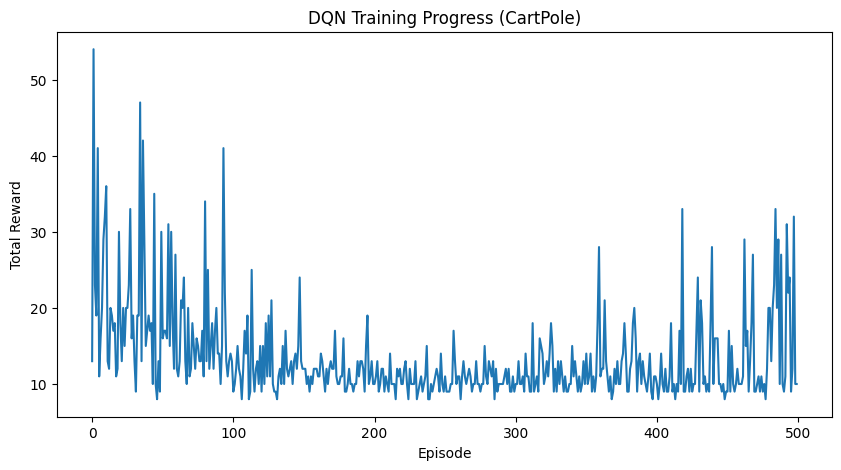

In [8]:
def plot_stats(stats):
    plt.figure(figsize=(10, 5))
    plt.plot(stats['Returns'])
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("DQN Training Progress (CartPole)")
    plt.show()

plot_stats(stats)

### 6.2 에이전트 테스트 및 시각화

학습된 에이전트가 균형을 잘 잡는지 확인한다.

Episode 3 finished in 9 steps.


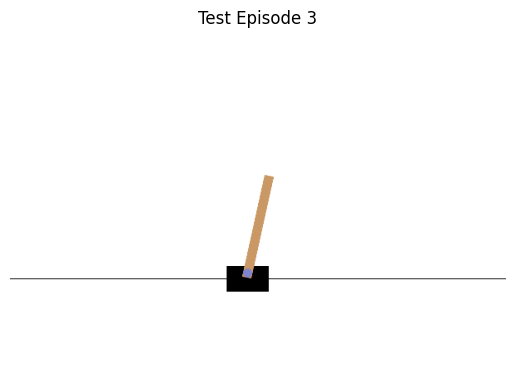

In [9]:
from IPython import display

def test_agent(env, policy, episodes=2):
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        step = 0

        img = plt.imshow(env.render())
        plt.axis('off')
        plt.title(f"Test Episode {ep+1}")

        while not done:
            # 테스트 시에는 무조건 Greedy 행동 (epsilon=0)
            action = policy(state, epsilon=0.0)
            state, reward, done, truncated, _ = env.step(action)

            img.set_data(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)
            step += 1

        print(f"Episode {ep+1} finished in {step} steps.")

# 테스트 실행
test_agent(env, policy, episodes=3)
env.close()

### 요약

DQN은 **리플레이 메모리**를 통해 데이터 효율성을 높이고 샘플 간 상관관계를 제거했으며, **타겟 네트워크**를 분리하여 학습의 목표값(Target)이 진동하는 문제를 해결했다. 이 두 가지 기법 덕분에 신경망을 이용한 강화학습이 안정적으로 수렴할 수 있게 되었다.